In [1]:
import cv2
import random
import json
import time

import torch
import numpy as np
from tqdm import tqdm

import clip
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from segment_anything.utils.transforms import ResizeLongestSide 

from PIL import Image  
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image

from sam_caf import hyper_params_tuning, get_crops, retrieve_relevant_crop, retrieve_relevant_crop_biomed, get_sam_prompts, sam_predicton, retrieve_relevant_crop_biomed_topk

In [2]:
#config
class DictToObject:
    def __init__(self, dict_obj):
        for key, value in dict_obj.items():
            setattr(self, key, value)

config_dict = {
    "model_name" : "SAM",
    "model_type" : "vit_h",
    "source":    "False", 
    "refine" : "False",
    "pre_trained": "True", 
    "sam_ckpt":  "/data/aofei/LLM/SAM/sam_vit_h_4b8939.pth", 
    "clip_prompts": "./clip_prompts/abd_seg.json"
}

config = DictToObject(config_dict)

prompt_mode, mode = "crops", "sam_clip"

def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (256, 256))
    return image

In [3]:
import os
# os.environ["TRANSFORMERS_CACHE"]="/data/aofei/huggingface_cache/transformers"
os.environ["HF_HOME"]="/data/aofei/huggingface_cache/transformers"
from open_clip import create_model_from_pretrained, get_tokenizer # works on open-clip-torch>=2.23.0, timm>=0.9.8

biomed_clip_model, biomed_preprocess = create_model_from_pretrained('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224', device="cuda")
tokenizer = get_tokenizer('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')

clip_model, preprocess = clip.load("ViT-L/14", device="cuda")
sam_checkpoint = config.sam_ckpt

sam = sam_model_registry[config.model_type](checkpoint=sam_checkpoint)
sam.to("cuda")
resize_transform = ResizeLongestSide(sam.image_encoder.img_size)

dice_scores = []
mask_generator, area = hyper_params_tuning(sam)

/data/aofei/conda/env/medh/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/data/aofei/conda/env/medh/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/data/aofei/conda/env/medh/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/data/aofei/conda/env/medh/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.

In [4]:
def sam_generation(image_path):
    image = preprocess_image(image_path=image_path)
    with torch.no_grad():
        # if mode == "sam_clip":
        masks = mask_generator.generate(image)
        masks = [mask for mask in masks if mask["area"] < area] # area filtering based on area value from hyper-params tuning
        img_crops = get_crops(image, masks, prompt_mode)
        
    return masks, img_crops

def filter_sam_results(masks, img_crops):
    new_masks, new_img_crops = [], []
    for i in range(len(masks)):
        mask = masks[i]
        if mask['bbox'][0] == 0 or mask['bbox'][1] == 0:
            continue
        if mask['bbox'][2] <= 12 or mask['bbox'][3] <= 12:
            continue
        y_max, x_max = mask['bbox'][1] + mask['bbox'][3], mask['bbox'][0] + mask['bbox'][2]
        if y_max > 253 or x_max > 253:
            continue
        new_masks.append(mask)
        new_img_crops.append(img_crops[i])
    return new_masks, new_img_crops

def get_topk_similar(k, crop_scores):
    sorted_scores = sorted([(i, m) for (i,m) in enumerate(crop_scores)], key=lambda x: x[1], reverse=True)
    return sorted_scores[:k]

def get_compelete_contour(masks):
    width_list = []
    # need to consider the chest xray
    for i in masks:
        width, height = i['bbox'][2], i['bbox'][3]
        width_list.append(width)
    sorted_width = sorted([(i, m) for (i,m) in  enumerate(width_list)], key=lambda x: x[1], reverse=True)
    return sorted_width[0][1]

def judge_inner_boxes(bboxes):
    for bbox in bboxes:
        bbox

In [5]:
masks_image_dict = dict()
crops_image_dict = dict()
def generate_segments(query, image_path):
    if masks_image_dict.__contains__(image_path):
        masks = masks_image_dict[image_path]
        img_crops = crops_image_dict[image_path]
    else:
        masks, img_crops = sam_generation(image_path=image_path)
        masks, img_crops = filter_sam_results(masks, img_crops)
        masks_image_dict[image_path] = masks
        crops_image_dict[image_path] = img_crops
    img_crops_filtered = img_crops
    prompts = {"query": [query]}
    max_indices, scores = retrieve_relevant_crop_biomed_topk(img_crops, prompts, biomed_clip_model, biomed_preprocess, config, tokenizer=tokenizer, topk=4)
    # topk_indices = get_topk_similar(3, scores["query"])
    # define a set of rules, firstly return top3
    # if there is no explicit organs to be used as query, then just use the whole segmentation
    # if the smaller boxes are in the bigger box, then use all of them but assign higher weights on smaller inner boxes
    bboxes = []
    # print(max_indices)
    for i in max_indices["query"]:
        bboxes.append(masks[i]["bbox"])
    return bboxes, max_indices["query"]

In [6]:
# Preprocessing for VQA-RAD
import json
with open(r"/data/aofei/hallucination/IU_Xray/data/training.json", "r") as f:
    train_data = json.load(f)
len(train_data)

1579

1797

In [7]:
train_data[1]

{'conversations': [{'from': 'human',
   'value': '<image>\nIs the cardiomediastinal silhouette abnormal in size or contour?'},
  {'from': 'gpt',
   'value': 'No, the cardiomediastinal silhouette appears to be stable in size and contour.'}],
 'image': 'CXR2079_IM-0711/0.png',
 'id': 1}

: 

In [8]:
set([i['location'] for i in train_data])

{'Abdomen',
 'Brain',
 'Brain_Face',
 'Brain_Tissue',
 'Chest_heart',
 'Chest_lung',
 'Chest_mediastinal',
 'Lung',
 'Neck',
 'Pelvic Cavity'}

In [13]:
# for i in range(len(train_rad_data)):
#failure case: 432-3 + 100
from tqdm import tqdm
for i in tqdm(range(len(train_data))):
    data = train_data[i]
    image_path = os.path.join("/data/aofei/hallucination/IU_Xray/iu_xray/images", data["img_name"])
    if "chest" in data['location'].lower():
        # query = f"Medical image of {data['image_organ']} and lungs. " + data["question"]
        query = f"{data['location']}"
    elif "abd" in data['location'].lower():
        query = f"Medical imgaing of abdomen." + data["question"]
        # query = f"Medical imgaing of abdomen."
    else:
        # query = f"Medical image of {data['image_organ']}. " + data["question"]
        query = f"Medical image of {data['location']}." + data["question"]
    bbox, max_indices = [], []
    try:
        bbox, max_indices = generate_segments(query, image_path)
    except:
        continue
    data['bbox'] = bbox
    data["bbox_indices"] = max_indices
    

In [14]:
s = 0
for i in train_data:
    if not i.__contains__("bbox"):
        s+= 1
s

191

In [17]:
#training2
new_train_data = []
for i in train_data:
    if i['q_lang'] != "en":
        continue
    template = dict()
    
    # template['answer_type'] = i['answer_type']
    template['image'] = i['img_name']
    template['id'] = i['qid']
    template['conversations'] = []
    template['bboxes'] = []
    if i.__contains__("bbox"):
        template['bboxes'] = i["bbox"]
    # template['text'] = i['question']

    new_qa = {"from": "human", "value": "<image>\n" + i['question']}
    new_qa2 = {"from": "gpt", "value": str(i['answer'])}
    template['conversations'] += [new_qa, new_qa2]
    new_train_data.append(template)

new_train_data[-1]

{'image': 'xmlab99/source.jpg',
 'id': 4918,
 'conversations': [{'from': 'human', 'value': '<image>\nIs the lung healthy?'},
  {'from': 'gpt', 'value': 'Yes'}],
 'bboxes': [[5, 58, 244, 183],
  [28, 80, 89, 132],
  [147, 140, 77, 72],
  [97, 173, 51, 56]]}

In [1]:
len(new_train_data)

NameError: name 'new_train_data' is not defined

In [19]:
with open('/data/aofei/hallucination/Slake/data/training_bboxes.json', 'w') as json_file:
    json.dump(new_train_data, json_file, indent=4)

In [63]:
# masks_image_dict[os.path.join("/data/aofei/hallucination/VQA_RAD/images", "synpic29265.jpg")][9]
new_train_data[0][0]

KeyError: 0

In [23]:
with open(r"/data/aofei/hallucination/Slake/test.json", "r") as f:
    test_data = json.load(f)
len(test_data)

#training2
new_test_data = []
for i in test_data:
    if i['q_lang'] != "en":
        continue
    template = dict()
    
    # template['answer_type'] = i['answer_type']
    template['image'] = i['img_name']
    template['id'] = i['qid']
    template['answer_type'] = i['answer_type']
    template['conversations'] = []

    new_qa = {"from": "human", "value": "<image>\n" + i['question']}
    new_qa2 = {"from": "gpt", "value": str(i['answer'])}
    template['conversations'] += [new_qa, new_qa2]
    new_test_data.append(template)

In [24]:
print(len(test_data))
with open('/data/aofei/hallucination/Slake/data/test.json', 'w') as json_file:
    json.dump(new_test_data, json_file, indent=4)

2094


In [6]:
import json
with open(r"/data/aofei/hallucination/Slake/data/training_bboxes.json", "r") as f:
    seg_train_data = json.load(f)
len(seg_train_data)
seg_train_dict = dict()
for i in seg_train_data:
    seg_train_dict[i['id']] = i

In [5]:
with open(r"/data/aofei/hallucination/Slake/train.json", "r") as f:
    train_data = json.load(f)
len(train_data)

9835

In [10]:
train_data[1]

{'img_id': 1,
 'img_name': 'xmlab1/source.jpg',
 'question': 'Which part of the body does this image belong to?',
 'answer': 'Abdomen',
 'q_lang': 'en',
 'location': 'Abdomen',
 'modality': 'MRI',
 'answer_type': 'OPEN',
 'base_type': 'vqa',
 'content_type': 'Position',
 'triple': ['vhead', '_', '_'],
 'qid': 1}

In [12]:
num_dict = dict()
ids_dict = dict()
for i in train_data:
    organ = i['location']
    id = i['qid']
    if num_dict.__contains__(organ):
        num_dict[organ] += 1
    else:
        num_dict[organ] = 1
    
    if ids_dict.__contains__(organ):
        ids_dict[organ].append(id)
    else:
        ids_dict[organ] = [id]

In [14]:
num_dict

{'Abdomen': 3041,
 'Lung': 3406,
 'Chest_heart': 187,
 'Chest_lung': 283,
 'Brain_Tissue': 1394,
 'Brain_Face': 250,
 'Brain': 543,
 'Neck': 264,
 'Chest_mediastinal': 33,
 'Pelvic Cavity': 434}

In [15]:
train_data_lungs = []
for _id in ids_dict['Lung']:
    if seg_train_dict.__contains__(_id):
        train_data_lungs.append(seg_train_dict[_id])

In [16]:
len(train_data_lungs)

1710

In [17]:
with open('/data/aofei/hallucination/Slake/data/training_bboxes_lung.json', 'w') as json_file:
    json.dump(train_data_lungs, json_file, indent=4)

In [18]:
train_data_lungs = []
for _id in ids_dict['Abdomen']:
    if seg_train_dict.__contains__(_id):
        train_data_lungs.append(seg_train_dict[_id])
with open('/data/aofei/hallucination/Slake/data/training_bboxes_abd.json', 'w') as json_file:
    json.dump(train_data_lungs, json_file, indent=4)

In [7]:
train_data[0]

{'img_id': 1,
 'img_name': 'xmlab1/source.jpg',
 'question': 'What modality is used to take this image?',
 'answer': 'MRI',
 'q_lang': 'en',
 'location': 'Abdomen',
 'modality': 'MRI',
 'answer_type': 'OPEN',
 'base_type': 'vqa',
 'content_type': 'Modality',
 'triple': ['vhead', '_', '_'],
 'qid': 0}

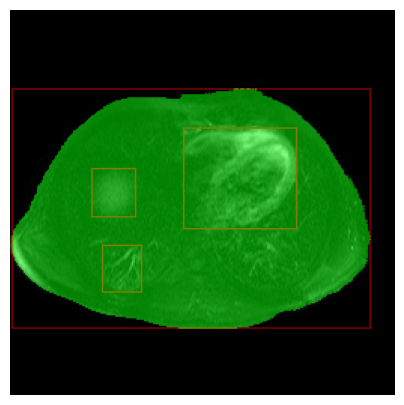

In [14]:
visualize_with_indices(image_name='xmlab1/source.jpg', indices_list=[3,0,2,1], fig_width=5)

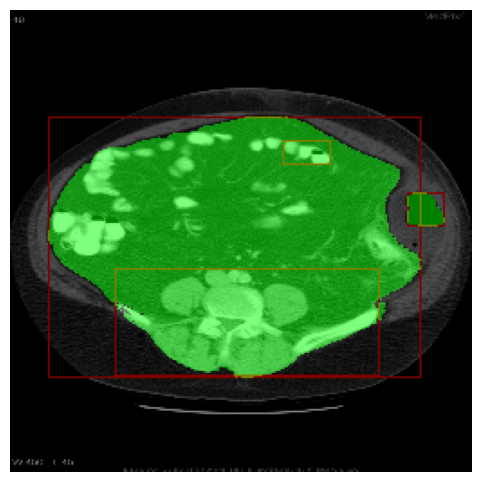

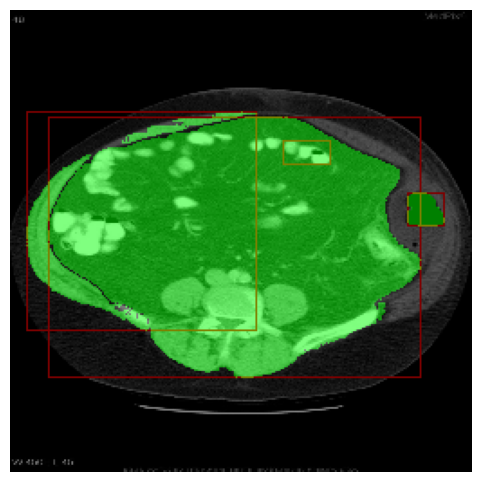

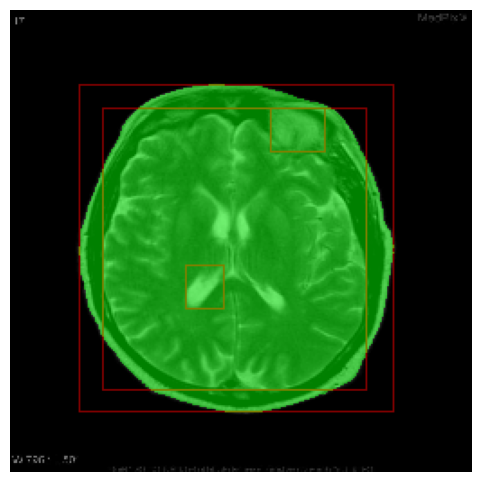

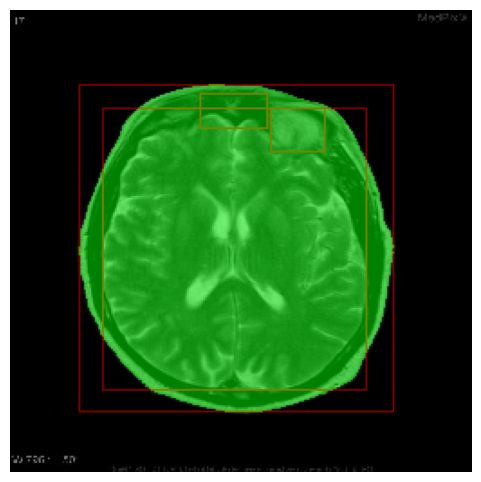

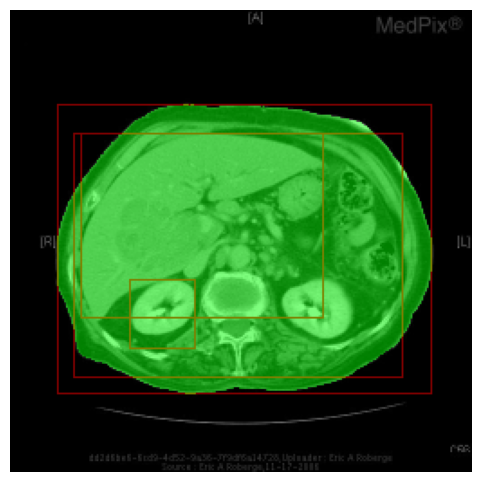

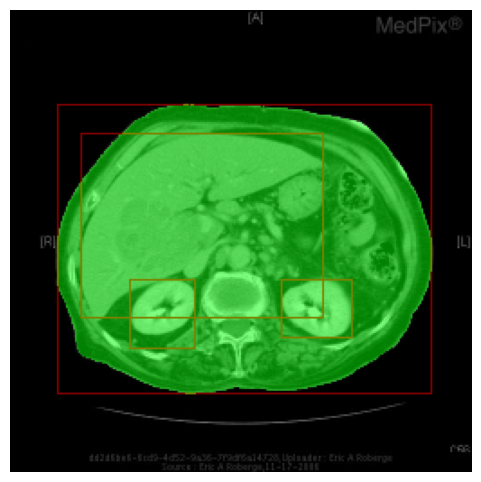

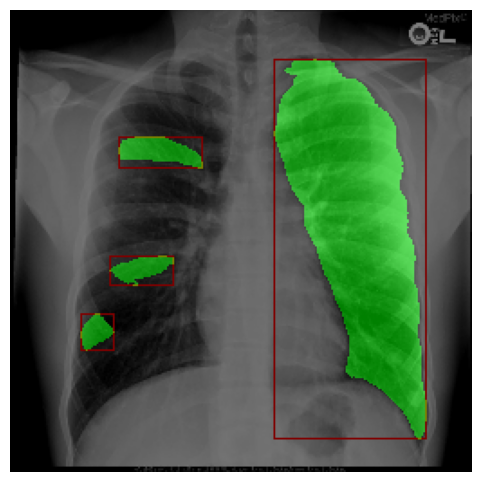

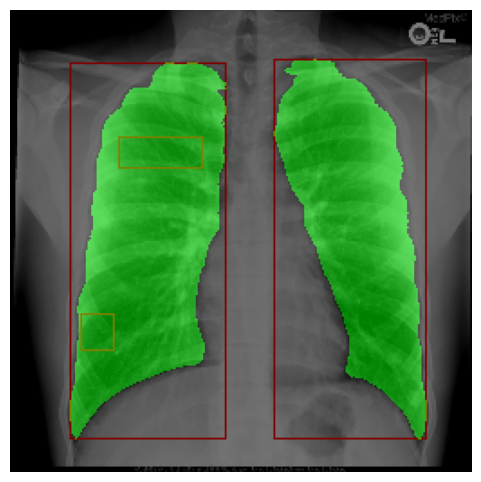

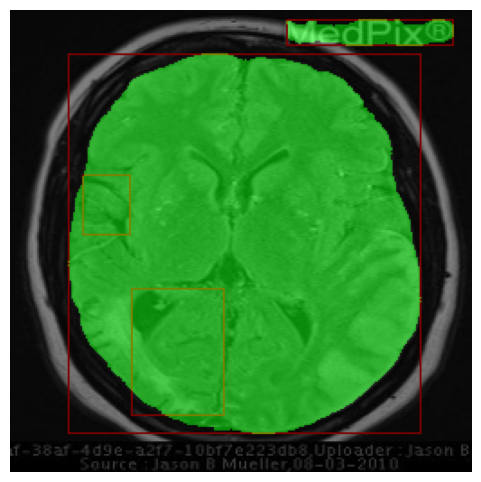

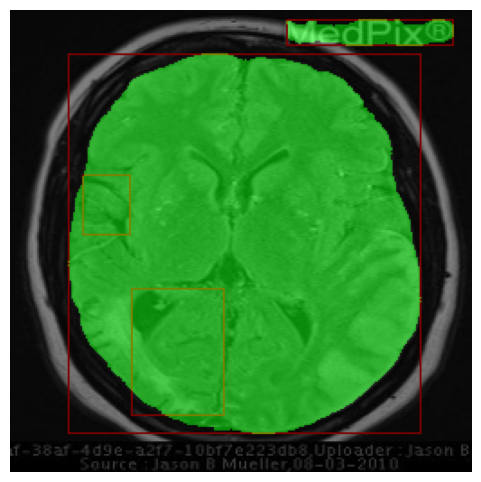

In [54]:
for i in train_rad_data[-20:-10]:
    image_name = i['image_name']
    indices_list = i['bbox_indices']
    visualize_with_indices(image_name=image_name, indices_list=indices_list)

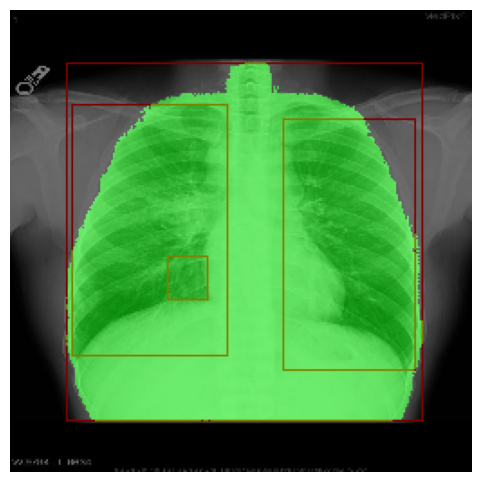

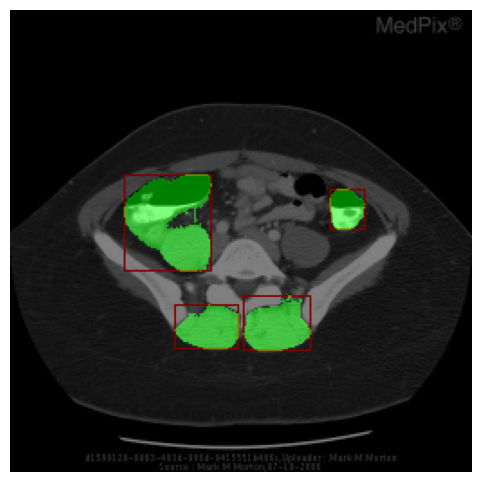

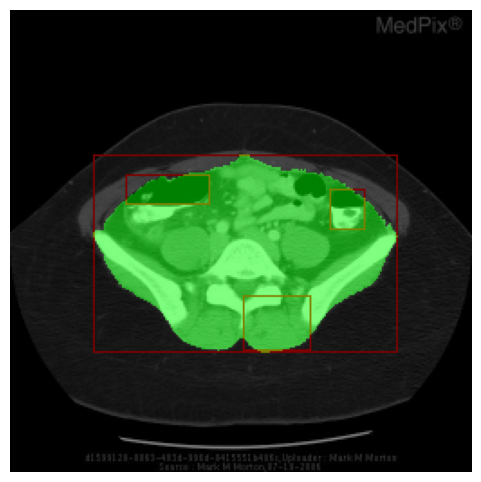

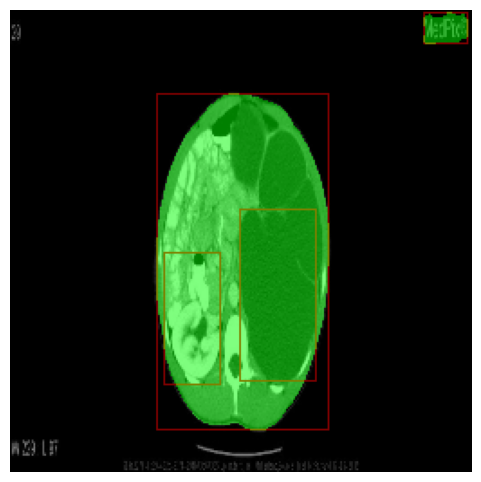

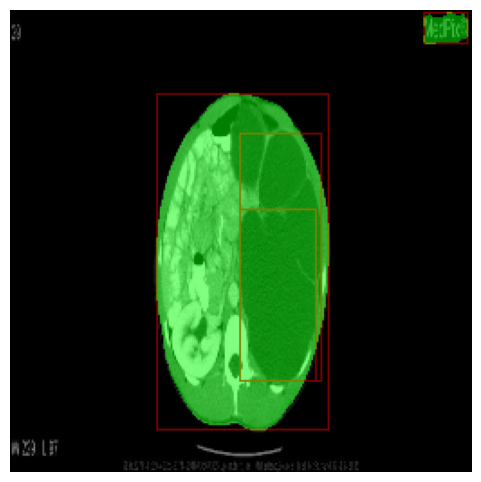

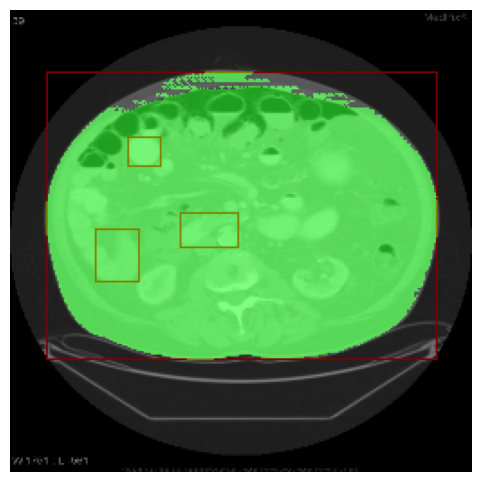

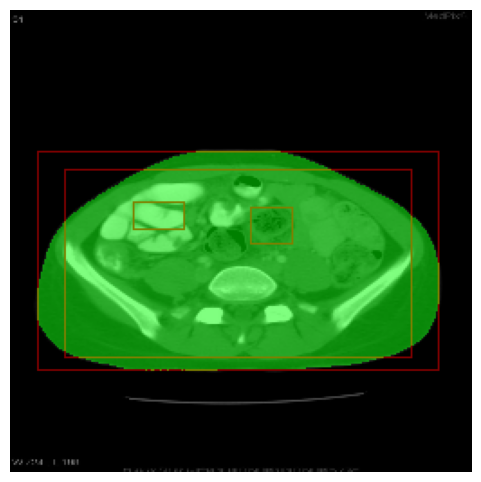

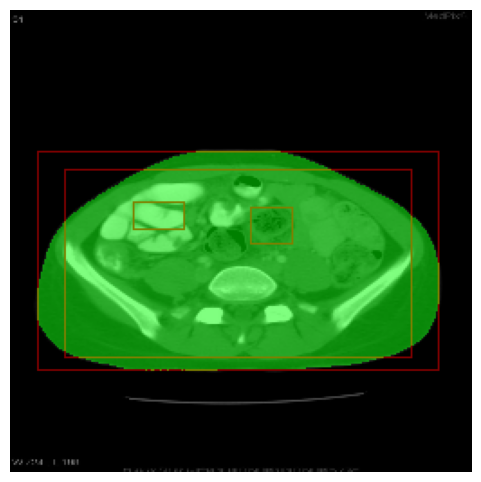

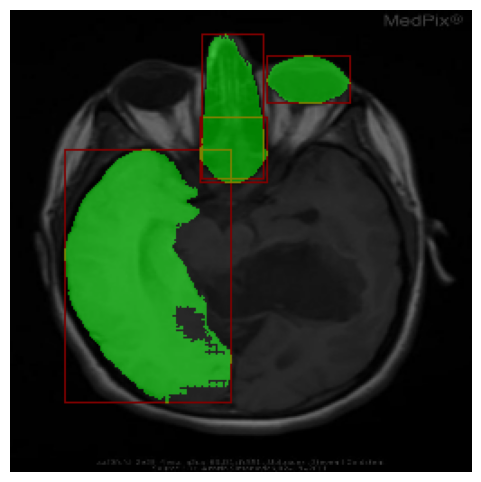

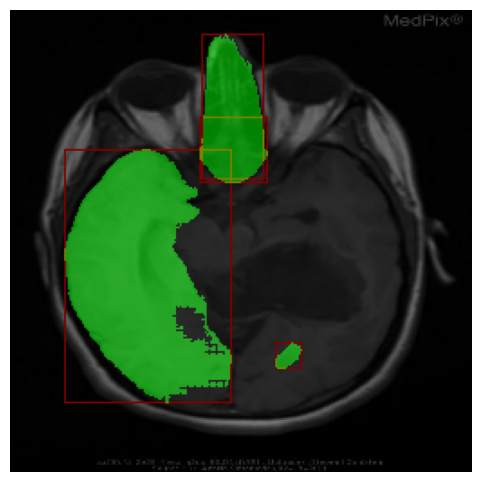

In [51]:
for i in train_rad_data[90:100]:
    image_name = i['image_name']
    indices_list = i['bbox_indices']
    visualize_with_indices(image_name=image_name, indices_list=indices_list)

In [180]:
# visualize_with_indices(image_name='synpic28602.jpg', indices_list=[3, 8, 9], fig_width=5)

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_with_indices(image_name, indices_list:list = None, indices:tuple = None, width_threshold=260, fig_width=6):
    image_path = os.path.join("/data/aofei/hallucination/Slake/imgs", image_name)
    masks = masks_image_dict[image_path]
    image = cv2.imread(image_path)
    image = cv2.resize(image, (256, 256))
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_with_boxes = image_rgb.copy()

    # Create an empty mask with the same size as the image
    combined_mask = np.zeros_like(image_rgb, dtype=np.uint8)

    # Loop over all segmentation results
    selected_masks = []
    if indices is not None:
        selected_masks = masks[indices[0]:indices[1]]
    elif indices_list is not None:
        for i in indices_list:
            selected_masks.append(masks[i])

    for seg in selected_masks:
        # Unpack bbox (bounding box)
        x, y, w, h = seg['bbox']
        if w >= width_threshold:
            continue

        # Draw the bounding box (in red)
        cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), (255, 0, 0), 1)

        # Extract and resize the segmentation mask
        mask = seg['segmentation'].astype(np.uint8)
        mask = cv2.resize(mask, (image_rgb.shape[1], image_rgb.shape[0]))  # Resize to fit the image

        # Add mask to combined mask (use a different color for each mask if desired)
        color_mask = np.zeros_like(image_rgb)
        color_mask[mask == 1] = [0, 255, 0]  # Green mask for the segment
        combined_mask = np.maximum(combined_mask, color_mask)

    # Blend the original image with the combined mask once
    alpha = 0.5  # Transparency factor
    image_with_masks = cv2.addWeighted(image_with_boxes, 1 - alpha, combined_mask, alpha, 0)

    # Display the image with bounding boxes and masks
    plt.figure(figsize=(fig_width, fig_width))
    plt.imshow(image_with_masks)
    plt.axis('off')  # Turn off axis for clean visualization
    plt.show()